## $$\text{Symmetric Wavefuncion}$$
- Sumit Kumar
- PH21B011

In [13]:
import numpy as np
from numba import njit
import math
from tqdm import tqdm
import matplotlib.pyplot as plt


In [15]:

# Trial wave function for H2
@njit(cache=True)
def trial_wavefunc_H2(r, alpha, beta, R):
    psi1 = np.exp(-alpha * np.linalg.norm(r[0] + np.array([0, 0, R/2])))
    psi1 += np.exp(-alpha * np.linalg.norm(r[0] - np.array([0, 0, R/2])))
    psi2 = np.exp(-alpha * np.linalg.norm(r[1] + np.array([0, 0, R/2])))
    psi2 += np.exp(-alpha * np.linalg.norm(r[1] - np.array([0, 0, R/2])))
    r12 = np.linalg.norm(r[0] - r[1]) + 1e-16
    jastrow = np.exp(r12 / (2 * (1 + beta * r12)))
    return psi1 * psi2 * jastrow

@njit(cache=True)
def local_energy_H2(r, alpha, beta, R):
    r1 = r[0]
    r2 = r[1]
    
    Rp1 = np.array([0.0, 0.0, -R/2])
    Rp2 = np.array([0.0, 0.0, R/2])
    
    r1p1_vec = r1 - Rp1
    r1p1 = np.linalg.norm(r1p1_vec) + 1e-16
    r1p1_hat = r1p1_vec / r1p1
    
    r1p2_vec = r1 - Rp2
    r1p2 = np.linalg.norm(r1p2_vec) + 1e-16
    r1p2_hat = r1p2_vec / r1p2
    
    r2p1_vec = r2 - Rp1
    r2p1 = np.linalg.norm(r2p1_vec) + 1e-16
    r2p1_hat = r2p1_vec / r2p1
    
    r2p2_vec = r2 - Rp2
    r2p2 = np.linalg.norm(r2p2_vec) + 1e-16
    r2p2_hat = r2p2_vec / r2p2
    
    phi1A = np.exp(-alpha * r1p1)
    phi1B = np.exp(-alpha * r1p2)
    phi2A = np.exp(-alpha * r2p1)
    phi2B = np.exp(-alpha * r2p2)
    
    denom1 = phi1A + phi1B + 1e-16
    denom2 = phi2A + phi2B + 1e-16
    
    G1 = (-alpha/denom1) * (phi1A * r1p1_hat + phi1B * r1p2_hat)
    G2 = (-alpha/denom2) * (phi2A * r2p1_hat + phi2B * r2p2_hat)
    
    K1 = (-0.5/denom1) * ((alpha**2 - 2*alpha/r1p1)*phi1A 
                         + (alpha**2 - 2*alpha/r1p2)*phi1B)
    K2 = (-0.5/denom2) * ((alpha**2 - 2*alpha/r2p1)*phi2A 
                         + (alpha**2 - 2*alpha/r2p2)*phi2B)
    
    r12_vec = r1 - r2
    r12 = np.linalg.norm(r12_vec) + 1e-16
    r12_hat = r12_vec / r12
    beta_r12 = beta * r12
    
    u_prime = 1.0 / (2 * (1 + beta_r12)**2)
    u_double_prime = -beta / (1 + beta_r12)**3
    
    jastrow_ke = u_double_prime + u_prime**2 + (2*u_prime)/r12
    cross_term = u_prime * np.dot(r12_hat, G1 - G2)
    
    KE = K1 + K2 - jastrow_ke - cross_term
    
    V = (-1.0/r1p1 - 1.0/r1p2 - 1.0/r2p1 - 1.0/r2p2 
         + 1.0/r12 + 1.0/R)
    
    return KE + V
# Metropolis sampling
@njit(cache=True)
def metropolis_sample_H2(r, alpha, beta, R, step, mcs):
    n, d = r.shape
    mean_energy = 0.0
    mean_sq_energy = 0.0
    mean_r12 = 0.0
    r_old = np.copy(r)
    thermalisation = 5000

    for i in range(thermalisation):
        r_new = r_old + (np.random.random((n, d)) - 0.5) * step
        wf_old = trial_wavefunc_H2(r_old, alpha, beta, R)
        wf_new = trial_wavefunc_H2(r_new, alpha, beta, R)
        if np.random.random() < (wf_new / wf_old) ** 2:
            r_old = r_new

    for i in range(mcs):
        r_new = r_old + (np.random.random((n, d)) - 0.5) * step
        wf_old = trial_wavefunc_H2(r_old, alpha, beta, R)
        wf_new = trial_wavefunc_H2(r_new, alpha, beta, R)
        if np.random.random() < (wf_new / wf_old) ** 2:
            r_old = r_new
        e = local_energy_H2(r_old, alpha, beta, R)
        mean_energy += e / mcs
        mean_sq_energy += e ** 2 / mcs
        mean_r12 += np.linalg.norm(r_old[0] - r_old[1]) / mcs
    return mean_energy, mean_sq_energy, mean_r12


In [16]:

# Main loop over R and beta
number_cycles = 2*10**4  # Reduce for testing, increase for production
step_length = 1.0
h = 0.001
h2 = 1 / h**2
number_particle = 2
dimension = 3
num_beta = 15
num_R = 20  # Number of R values to scan
betas = np.linspace(0.0, 0.5, num_beta)
Rs = np.linspace(0.4, 2.5, num_R)  # In Bohr radii

results = []
def solve_alpha(R, tol=1e-8, max_iter=100):
    alpha = 1.0
    for _ in range(max_iter):
        alpha_new = 1 + np.exp(-R / alpha)
        if abs(alpha_new - alpha) < tol:
            return alpha_new
        alpha = alpha_new
    return alpha
alphas = [solve_alpha(i) for i in Rs]

for i in tqdm(range(len(Rs))):
    best_energy = 1e10
    best_beta = 0.0
    best_r12 = 0.0
    # Use the cusp condition for alpha (see your text)
    alpha = alphas[i]
    for beta in betas:
        r_init = step_length * (np.random.random((number_particle, dimension)) - 0.5)
        mean_energy, mean_sq_energy, mean_r12 = metropolis_sample_H2(
            r_init, alpha, beta, Rs[i], step_length, number_cycles
        )
        if mean_energy < best_energy:
            best_energy = mean_energy
            best_beta = beta
            best_r12 = mean_r12
    results.append((Rs[i], best_energy, best_beta, best_r12))

# Convert to numpy array for plotting
results = np.array(results)


100%|██████████| 20/20 [00:48<00:00,  2.43s/it]


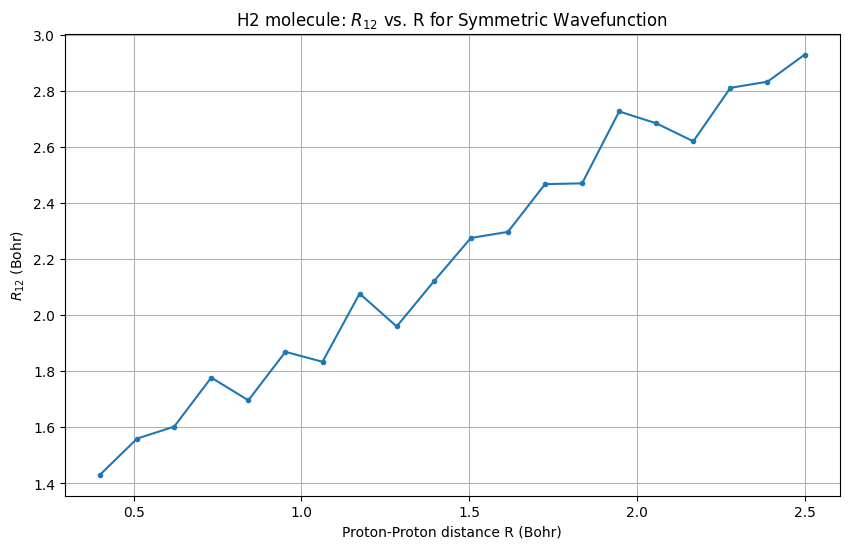

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(results[:,0], results[:,3],'.-')
plt.grid()
plt.xlabel("Proton-Proton distance R (Bohr)")
plt.ylabel("$R_{12}$ (Bohr)")
plt.title("H2 molecule: $R_{12}$ vs. R for Symmetric Wavefunction")
plt.show()

In [19]:
import pandas as pd

data = {
    'R':results[:,0],
    '$R_{12}$':results[:,3]
}
df = pd.DataFrame(data)
df = pd.DataFrame(data)

# Convert DataFrame to LaTeX table string
latex_table = df.to_latex(
    index=False,           # Exclude index column
    header=True,           # Include column headers
    float_format="%.2f",   # Format float values
    caption="Sample Table", # Add caption
    label="tab:sample_table", # Add label for referencing
    column_format="lcc"    # Align columns (left, center, center)
)

# Print the LaTeX table string
print(latex_table)

\begin{table}
\caption{Sample Table}
\label{tab:sample_table}
\begin{tabular}{lcc}
\toprule
R & $R_{12}$ \\
\midrule
0.40 & 1.43 \\
0.51 & 1.56 \\
0.62 & 1.60 \\
0.73 & 1.78 \\
0.84 & 1.70 \\
0.95 & 1.87 \\
1.06 & 1.83 \\
1.17 & 2.08 \\
1.28 & 1.96 \\
1.39 & 2.12 \\
1.51 & 2.27 \\
1.62 & 2.30 \\
1.73 & 2.47 \\
1.84 & 2.47 \\
1.95 & 2.73 \\
2.06 & 2.68 \\
2.17 & 2.62 \\
2.28 & 2.81 \\
2.39 & 2.83 \\
2.50 & 2.93 \\
\bottomrule
\end{tabular}
\end{table}

